Here is a whistlestop tour of what pysystemtrade can currently do. You'll probably want to read the [users guide](backtesting.md) after this.
Notice that you will see different results than shown here, as you will be using more up to date data.

## A simple trading rule

(code is [here](/examples/introduction/asimpletradingrule.py) )

As systematic traders we believe that the future will be at least a bit like the past. So first of all we need some past data. In principle past data can come from many places, but to begin with we'll get it from some pre-baked .csv files:


In [3]:
from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
data=csvFuturesSimData()
data

2022-10-07 20:35:41 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2022-10-07 20:35:41 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2022-10-07 20:35:41 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2022-10-07 20:35:41 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2022-10-07 20:35:41 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)


csvFuturesSimData object with 163 instruments

What instruments have we got?

In [4]:
data.get_instrument_list()

['FTSECHINAH',
 'EU-MID',
 'EU-DIV30',
 'JP-REALESTATE',
 'SMI',
 'DJSTX-SMALL',
 'EUROSTX200-LARGE',
 'PALLAD',
 'GBPEUR',
 'SP500_micro',
 'BOVESPA',
 'IRON',
 'LEANHOG',
 'GAS-LAST',
 'US-STAPLES',
 'ETHER-micro',
 'VNKI',
 'SOYBEAN',
 'EU-DJ-UTIL',
 'FTSEINDO',
 'NZD',
 'ETHANOL',
 'GOLD',
 'MSCIASIA',
 'EU-DJ-TECH',
 'EU-TECH',
 'SMI-MID',
 'NIFTY',
 'BTP',
 'EU-TRAVEL',
 'NASDAQ_micro',
 'AEX',
 'BBCOMM',
 'NASDAQ',
 'EU-HOUSE',
 'NIKKEI400',
 'RUSSELL',
 'USIRS10',
 'EU-HEALTH',
 'SILVER',
 'LUMBER',
 'CHEESE',
 'EURCHF',
 'MILKWET',
 'CAC',
 'AUD',
 'EU-CHEM',
 'EU-DJ-OIL',
 'BUND',
 'EU-FOOD',
 'US-MATERIAL',
 'US10',
 'KR10',
 'BEL20',
 'US-UTILS',
 'EU-RETAIL',
 'INR',
 'OMX',
 'CZK',
 'COPPER',
 'CLP',
 'FEEDCOW',
 'EU-BANKS',
 'BRE',
 'LIVECOW',
 'BTP3',
 'CAD',
 'SGX',
 'KOSDAQ',
 'MSCISING',
 'COPPER-mini',
 'R1000',
 'HEATOIL',
 'CH10',
 'JGB-SGX-mini',
 'GASOILINE',
 'CNH',
 'EUROSTX',
 'RICE',
 'EU-REALESTATE',
 'EUR',
 'BUXL',
 'RUR',
 'US5',
 'US30',
 'JGB',
 'CRUDE

Not all the instruments are easily identifiable

In [5]:
data.get_instrument_object_with_meta_data("MUMMY")


futuresInstrumentWithMetaData(instrument=MUMMY, meta_data={'Description': 'TSE Mothers Index', 'Pointsize': 1000.0, 'Currency': 'JPY', 'AssetClass': 'Equity', 'Slippage': 0.5, 'PerBlock': 50.0, 'Percentage': 0.0, 'PerTrade': 0.0})

And what kind of data can we get for them?

In [6]:
data.get_raw_price("EDOLLAR").tail(5)

index
2022-09-29 23:00:00    96.225
2022-09-30 14:30:00    96.320
2022-09-30 15:00:00    96.265
2022-09-30 16:00:00    96.275
2022-09-30 17:00:00    96.265
Name: price, dtype: float64

*I'll update the data regularly, as well as including methods for you to get your own data from different sources*

*Technical note: This is the 'back-adjusted' price for the future, formed from stitching adjacent contracts together using the 'panama' method*

`data` objects behave a bit like dicts (though they don't formally inherit from them). So these both work:


In [7]:
data.keys() ## equivalent to data.get_instrument_list
data['SP500_micro'] ## equivalent to data.get_instrument_price

index
1982-09-14 23:00:00     405.40
1982-09-15 23:00:00     405.90
1982-09-16 23:00:00     405.25
1982-09-17 23:00:00     404.35
1982-09-20 23:00:00     405.15
                        ...   
2022-09-30 15:00:00    3666.75
2022-09-30 16:00:00    3654.50
2022-09-30 17:00:00    3651.75
2022-09-30 18:00:00    3634.75
2022-09-30 19:00:00    3638.50
Name: price, Length: 32533, dtype: float64

Price data is useful, but is there any other data available? For futures, yes, we can get the data we need to implement a carry rule:

In [8]:
data.get_instrument_raw_carry_data("EDOLLAR").tail(6)

,PRICE,CARRY,PRICE_CONTRACT,CARRY_CONTRACT
index,,,,
2022-09-29 21:00:00,96.225,96.215,20251200,20250900
2022-09-29 23:00:00,96.225,96.215,20251200,20250900
2022-09-30 14:30:00,96.320,96.295,20251200,20250900
2022-09-30 15:00:00,96.265,96.245,20251200,20250900
2022-09-30 16:00:00,96.275,96.260,20251200,20250900
2022-09-30 17:00:00,96.265,96.250,20251200,20250900


Let's create a simple trading rule.

In [9]:
import pandas as pd
from sysquant.estimators.vol import robust_vol_calc


def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading rule forecast, given a price and EWMA speeds Lfast, Lslow and vol_lookback

    """
    ## price: This is the stitched price series
    ## We can't use the price of the contract we're trading, or the volatility will be jumpy
    ## And we'll miss out on the rolldown. See https://qoppac.blogspot.com/2015/05/systems-building-futures-rolling.html

    price = price.resample("1B").last()
    if Lslow is None:
        Lslow = 4 * Lfast

    ## We don't need to calculate the decay parameter, just use the span directly

    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma

    vol = robust_vol_calc(price.diff())

    return raw_ewmac / vol

Let's run it and look at the output

In [13]:
instrument_code='EDOLLAR'
price=data.daily_prices(instrument_code)
ewmac=calc_ewmac_forecast(price, 32, 128)
ewmac.tail(5)


index
2022-09-26   -4.063877
2022-09-27   -4.459054
2022-09-28   -3.842633
2022-09-29   -4.073326
2022-09-30   -4.263597
Freq: B, Name: price, dtype: float64

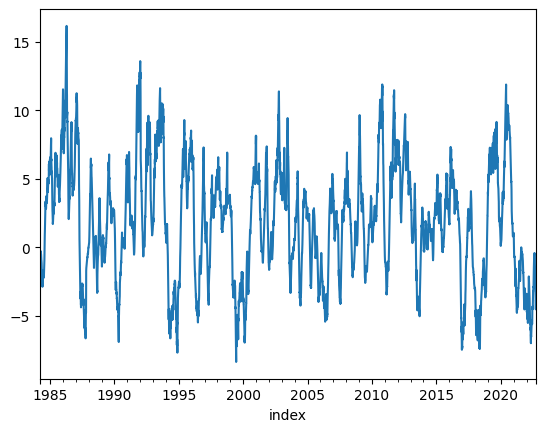

In [14]:
from matplotlib.pyplot import show
ewmac.plot()
show()

Did we make any money?


In [17]:
from systems.accounts.account_forecast import pandl_for_instrument_forecast
account = pandl_for_instrument_forecast(forecast = ewmac, price=price)
account.percent.stats()

[[('min', '-5.81'),
  ('max', '5.141'),
  ('median', '0'),
  ('mean', '0.01386'),
  ('std', '0.4962'),
  ('skew', '-0.2208'),
  ('ann_mean', '3.547'),
  ('ann_std', '7.938'),
  ('sharpe', '0.4468'),
  ('sortino', '0.526'),
  ('avg_drawdown', '-11.29'),
  ('time_in_drawdown', '0.9733'),
  ('calmar', '0.09848'),
  ('avg_return_to_drawdown', '0.3141'),
  ('avg_loss', '-0.3167'),
  ('avg_gain', '0.3232'),
  ('gaintolossratio', '1.02'),
  ('profitfactor', '1.1'),
  ('hitrate', '0.5188'),
  ('t_stat', '2.8'),
  ('p_value', '0.005123')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent'])]

Looks like we did make a few bucks. `account`, by the way inherits from a pandas data frame. Here are some other things we can do with it:

3.547166797339901

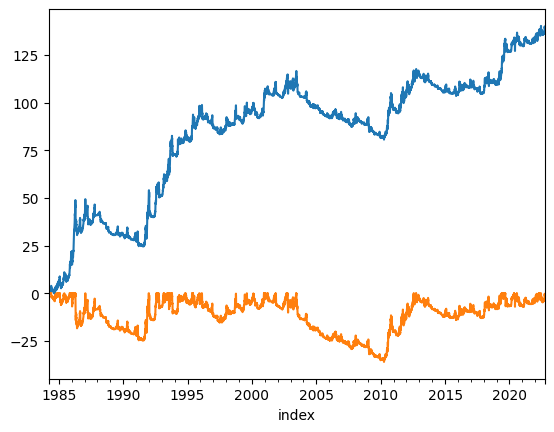

In [18]:
account.sharpe() ## get the Sharpe Ratio (annualised), and any other statistic which is in the stats list
account.curve().plot() ## plot the cumulative account curve (equivalent to account.cumsum().plot() inicidentally)
account.percent ## gives a % curve
account.percent.drawdown().plot() ## see the drawdowns as a percentage
account.weekly ## weekly returns (also daily [default], monthly, annual)
account.gross.ann_mean() ## annual mean for gross returns, also costs (there are none in this simple example)

[Here](notebooks/introduction_with_fxdata.ipynb) you can find a modified version of this example using IB data instead of pre-baked CSV data files.

## A simple system

(code is [here](/examples/introduction/simplesystem.py) )

This is all very well, but what we probably want to do is build a trading **system** composed of several trading rules, and a few more instruments.

A system consists of some `data` (which we've already seen), a number of processing *stages*, and optionally a configuration to modify how each of the stages behaves.

A full list of stages would include:

1. Preprocessing some raw data (which we don't cover in this introduction)
2. Running some trading rules over it to generate forecasts
3. Scaling and capping those forecasts
4. Combining forecasts together
5. Position sizing
6. Creating a portfolio of instruments
7. Working out the p&l

For now let's start with the simplest possible system, one which contains only a trading rules stage. Let's just setup our environment again:

In [20]:
from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
data=csvFuturesSimData()

from systems.provided.rules.ewmac import ewmac_forecast_with_defaults as ewmac

2022-10-07 21:43:07 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2022-10-07 21:43:07 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2022-10-07 21:43:07 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2022-10-07 21:43:07 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2022-10-07 21:43:07 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)


This is a slightly different version of the rule we defined before, which has default values for `Lfast` and `Lslow`. Now there are many ways to create a set of trading rules; here is the simplest:

In [21]:
from systems.forecasting import Rules
my_rules=Rules(ewmac)
my_rules.trading_rules()

{'rule0': TradingRule; function: <function ewmac_forecast_with_defaults at 0x7fdbb942f8b0>, data: data.daily_prices (args: {}) and other_args: }

This won't make much sense now, but bear with me (and don't worry if you get a different hexadecimal number). Suffice to say we've created a dict of trading rules with one variation, which has been given the thrilling name of `rule0`. `rule0` isn't especially meaningful, so let's come up with a better name:

In [22]:
my_rules=Rules(dict(ewmac=ewmac))
my_rules.trading_rules()

{'ewmac': TradingRule; function: <function ewmac_forecast_with_defaults at 0x7fdbb942f8b0>, data: data.daily_prices (args: {}) and other_args: }

The next stage is to create a system incorporating our `data` object, and the `my_rules` stage.

In [25]:
from systems.basesystem import System
my_system=System([my_rules], data)
my_system

System base_system with .config, .data, and .stages: rules

We can now get forecasts:


In [26]:
my_system.rules.get_raw_forecast("EDOLLAR", "ewmac").tail(5)


index
2022-09-26   -1.006302
2022-09-27   -1.003630
2022-09-28   -1.029374
2022-09-29   -1.051614
2022-09-30   -1.077200
Freq: B, Name: price, dtype: float64